In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 219 (delta 123), reused 168 (delta 85), pack-reused 0
Receiving objects: 100% (219/219), 2.68 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Mounted at /content/drive


In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
from cxlayers import ImageToElectricField, CxMO, AngularSpectrum, CxD2NNIntensity, D2NNMNISTDetector, ImageResizing, D2NNMNISTFilter, CxD2NNFaradayRotation, GGG, ImageBinarization, Polarizer
import os
# import matplotlib_style
import glob
import re

tf.experimental.numpy.experimental_enable_numpy_behavior()
print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]


In [26]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

In [2]:
path = 'trained_model/20220424_6'
model = tf.keras.models.load_model(path)
model.summary()

2022-04-26 15:09:02.800292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-26 15:09:02.800654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_11 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_11 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 image_to_electric_field_11   (None, 2, 2, 100, 100)   0         
 (ImageToElectricField)                                          
                                                                 
 cx_mo_55 (CxMO)             (None, 2, 2, 100, 100)    10002     
                            

## 正解率

In [ ]:
history = pd.read_csv(path + '/history.csv')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, history.index.stop + 1), history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, history.index.stop + 1), history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

# model.evaluate(x_test, y_test)

## 混同行列

In [ ]:
pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
cm = tf.math.confusion_matrix(y_test, pred_label)
label_tot = np.sum(cm, axis=1).reshape(-1, 1)
norm_cm = cm/label_tot

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(norm_cm, square=True, cbar=False, annot=True, fmt=".2f", cmap='BuPu')
plt.rcParams["font.size"] = 13
plt.xlabel("Predicted label", fontsize=13)
plt.ylabel("True label", fontsize=13)
plt.title("Normalized confusion matrix")

## 位相変調層

In [ ]:
plt.imshow(2.1 * np.pi / 180* tf.sin(model.layers[4].get_weights()[0]), cmap='plasma')
plt.colorbar()

## 出力プロット

In [ ]:
layer_name = model.layers[-3].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num + 0, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output")
        axes[i, 2].set_title("Filtered Output")
        axes[i, 3].set_title("Predict")
        
fig.tight_layout()

## 途中出力可視化

In [24]:
output_class = CxD2NNIntensity
pattern = 'angular_spectrum'
outputs = []
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        outputs.append(output_class((100, 100))(layer.output))

hidden_layer_model = tf.keras.Model(model.inputs, outputs=outputs)

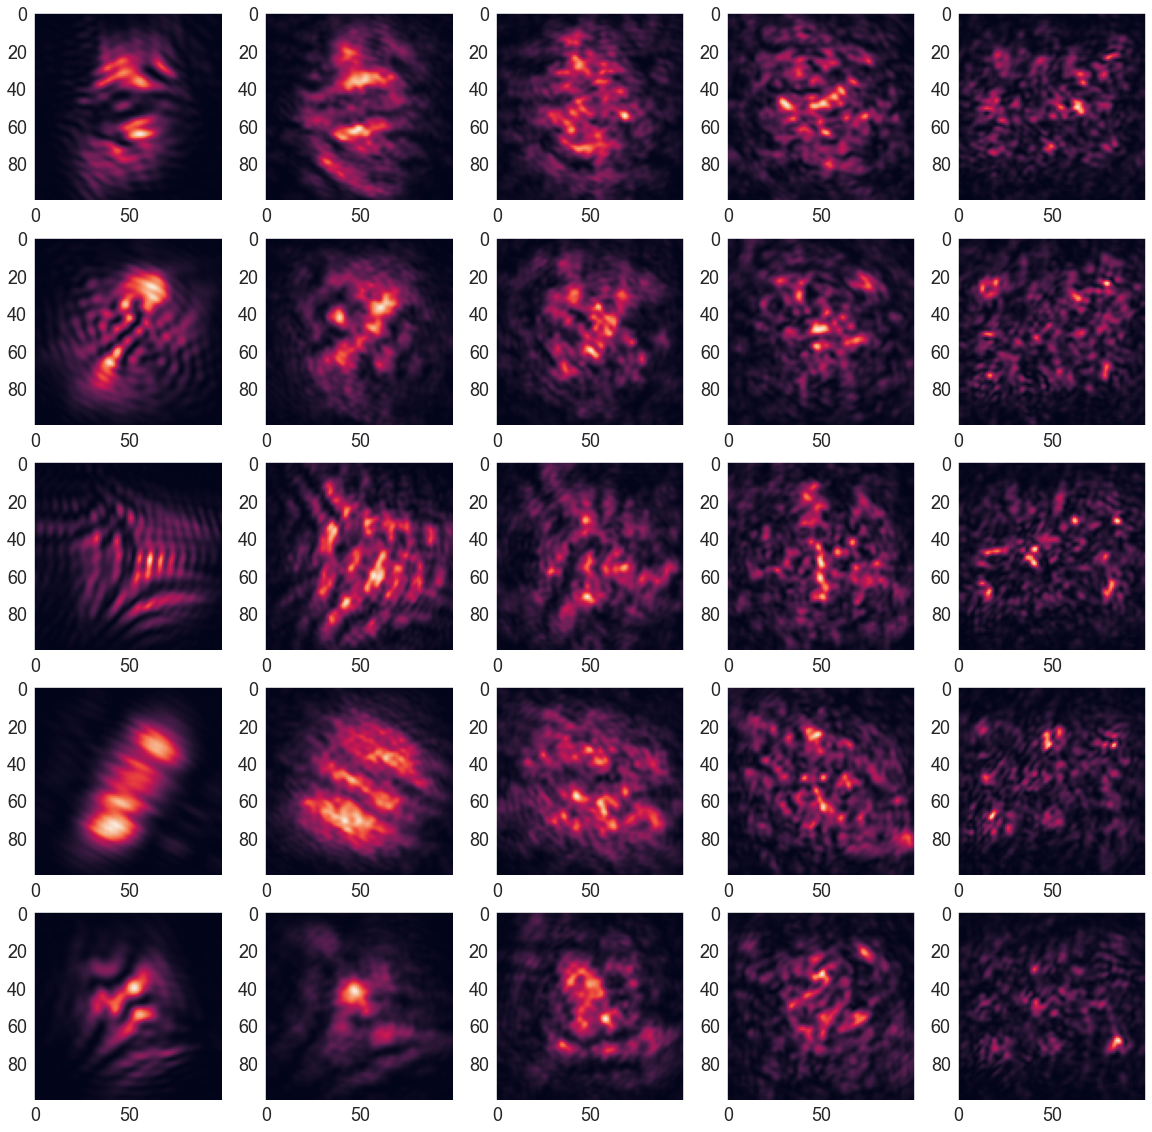

In [39]:
images_num = 5
pred = hidden_layer_model.predict(x_train[0:images_num,:,:])
fig, axes = plt.subplots(images_num, len(pred), figsize=(4 * len(pred), 4 * images_num))
for i, _ax in enumerate(axes):
    for j, ax in enumerate(_ax):
        ax.imshow(pred[j][i,:,:])
        ax.grid(False)

## 2値化して出力プロット

In [ ]:
mo_layer_index = [4, 6]
limit_value = 2.1 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None

layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

In [ ]:
model.evaluate(x_test, y_test)

## 位相変調量

In [ ]:
bi_phase = model.layers[5].get_weights()[0]
plt.imshow(bi_phase, cmap='plasma', interpolation='none')
plt.colorbar()
bi_phase = np.where(bi_phase >= 0, 1, -1)
np.savetxt('data/phase/20220319-1/layer2.csv', bi_phase, fmt='%d', delimiter=',')

## 学習過程の正解率比較

In [ ]:
path = 'trained_model'
files = glob.glob(path + '/20220317*/history.csv')
labels = [r'$\pm 90\degree$', r'$\pm 45 \degree$', r'$\pm 10 \degree$']
for i, file in enumerate(files):
    history = pd.read_csv(file)
    plt.plot(range(1, history.index.stop + 1), history['accuracy'], label=labels[i])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("epoch")

## 3値化

In [ ]:
mo_layer_index = [3]
sep = 90 * np.pi / 180
limit_value = 90 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None

In [ ]:
model.get_weights()[2]

In [ ]:
shape = (100, 100)
inputs = tf.keras.layers.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0, 1)(x)
x = ImageToElectricField(shape)(x)
x = CxMO(shape)(x)
x = AngularSpectrum(shape, 531e-9, 0.5e-3, 2.0e-6, n=1, normalization='max', method='expand')(x)
x = CxMO(shape)(x)
x = AngularSpectrum(shape, 531e-9, 2.0e-3, 2.0e-6, n=1, normalization='max', method='expand')(x)
x = Polarizer(shape, phi=-np.pi/2, trainable=True)(x)
x = CxD2NNIntensity(shape)(x)
x = D2NNMNISTDetector(10, activation='softmax')(x)

testmodel = tf.keras.Model(inputs, x)
testmodel.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])
testmodel.layers[4].set_weights(2.1*np.pi/180*tf.tanh(model.layers[4].get_weights()))

In [ ]:
testmodel.layers[6].set_weights(2.1*np.pi/180*tf.tanh(model.layers[6].get_weights()))

In [ ]:
testmodel.layers[-3].phi

In [ ]:
testmodel.evaluate(x_test, y_test)

# 複数モデル比較

## 学習経過

In [ ]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220415_*/*.csv"
files = glob.glob(path)
files.sort(reverse=True)
plt.figure(figsize=(7, 4))
lines = []
for i, file in enumerate(files):
    result = pd.read_csv(file)
    lines.append(plt.plot(result["val_accuracy"], label=label[i]))

plt.legend(title=r'$\Delta \phi$', loc='upper left', bbox_to_anchor=(1, 1))
plt.yticks(np.arange(0, 1.1, 0.1), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel("Accuracy")
plt.xlabel("Epoch Number")
plt.tight_layout()